**Imports**

In [608]:
# ---------------------------------------------- Imports ----------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time

**Constantes**

In [609]:
L = 0.230
R = 0.035
ROBOT = "kobuki"
LASER = "fastHokuyo"

robot_path = []
obstacle_points = []

# Tamanho da célula do nosso Grid (em metros)
CELL_SIZE = 0.1
# CELL_SIZE = 0.1
# CELL_SIZE = 0.5

# Dimensão do meu Mapa
MAP_DIMS = np.array([10,10])

#Meu grid
rows, cols = (MAP_DIMS/CELL_SIZE).astype(int)
grid = np.full((rows, cols), 0.5)
# fig, ax = plt.subplots()
# cax = ax.matshow(grid, cmap='gray_r', vmin=0, vmax=1)
# fig.colorbar(cax)
# ax.set_title('Occupancy Grid Map')
# ax.set_xlabel('X (cells)')
# ax.set_ylabel('Y (cells)')
# ax.set_xticks(np.arange(0, MAP_DIMS[1]+1, CELL_SIZE))
# ax.set_yticks(np.arange(0, MAP_DIMS[0]+1, CELL_SIZE))

#Vetor para realizar a translação!
pBorg = [-5, -5]


**Init**

In [610]:
# ---------------------------------------------- Init ----------------------------------------
try:
    client = RemoteAPIClient()
    sim = client.require('sim')
except:
    print('Error connection')

**Leitura do Sensor**

In [611]:
def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):
    
    signalName = sim.waitForSignal(range_data_signal_id)
    
    string_range_data = sim.getStringSignal(range_data_signal_id)

    string_angle_data = sim.getStringSignal(angle_data_signal_id)

    # verifique se ambos os dados foram obtidos corretamente
    if string_range_data != None and string_angle_data != None:
        # descompacte dados de mensagens de alcance e sensor
        raw_range_data = sim.unpackFloatTable(string_range_data)
        raw_angle_data = sim.unpackFloatTable(string_angle_data)

        return raw_range_data, raw_angle_data

    # retornar nenhum caso nada tenha sido obtido do simulador
    return None

**Cálculo Matriz de Rotação**

In [612]:
def get_rotation_matrix(thetaZ):
    return np.array([[  np.cos(thetaZ), -np.sin(thetaZ), 0 ],
                      [ np.sin(thetaZ),  np.cos(thetaZ), 0 ],
                      [ 0            ,  0            , 1 ]])

def get_rotation_matrix_laser_world():
    objectHandle_RP = sim.getObject("/" + ROBOT)
    origin_RP = np.array(sim.getObjectPosition(objectHandle_RP, 
                                        sim.handle_world))

    objectHandle_Laser = sim.getObject("/" + LASER)
    origin_Laser = np.array(sim.getObjectPosition(objectHandle_Laser, 
                                        sim.handle_world))
    p_Laserorg = origin_Laser - origin_RP
    eulerAngles_Laser = sim.getObjectOrientation(objectHandle_Laser, 
                                                objectHandle_RP)

    aux = np.array([0, 0, 0, 1])
    rotationMatrix_Laser = get_rotation_matrix(eulerAngles_Laser[2])
    transformationMatrix_Laser = np.column_stack((rotationMatrix_Laser, p_Laserorg))
    transformationMatrix_Laser = np.row_stack((transformationMatrix_Laser, aux))

    #Matriz de Transformação Robô -> mundo
    origin_World = np.array([0,0,0])
    p_RPorg = origin_RP - origin_World
    eulerAngles_RP = sim.getObjectOrientation(objectHandle_RP, 
                                                sim.handle_world)
    rotationMatrix_RP = get_rotation_matrix(eulerAngles_RP[2])
    transformationMatrix_World = np.column_stack((rotationMatrix_RP, p_RPorg))
    transformationMatrix_World = np.row_stack((transformationMatrix_World, aux))
    
    #Matriz de Transformação Laser -> Mundo
    return transformationMatrix_Laser @ transformationMatrix_World
    # matrix_copelia = sim.getObjectMatrix(objectHandle_Laser)
    # matrix = np.array(matrix_copelia)
    # matrix_reshape = matrix.reshape(3,4)
    # # matrix = np.array([matrix_copelia[0],matrix_copelia[1],matrix_copelia[2],matrix_copelia[3]],
    # #                   [matrix_copelia[4],matrix_copelia[5],matrix_copelia[6],matrix_copelia[7]],
    # #                   [matrix_copelia[8],matrix_copelia[9],matrix_copelia[10],matrix_copelia[11]])
    # matrix_reshape = np.row_stack((matrix_reshape, aux))
    # return matrix_reshape

**Campos Potenciais**

In [613]:
#Calcula a força de atração 
def att_force(q, goal, k=5):
    f = k*(goal - q)
    return f

#Calcula a força de repulsão
def rep_force(q, obs, R=1.5, krep=.005):
    Frep_total = np.array([0.0, 0.0])
    for obstacle in obs:
        v = q[0:2] - obstacle
        d = np.linalg.norm(v) # Calcula a distância entre o robô e o obstáculo

        # Calcula a força de repulsão apenas se a distância for menor que R
        if (d < R):  
            rep = (1/d**2)*((1/d)-(1/R))*(v/d) 
            Frep_total += rep

    return krep*Frep_total

**Occupancy Grid**

In [614]:
# def plot_occupancy_grid_mapping():
#     fig = plt.figure(figsize=(8,8), dpi=100)
#     ax = fig.add_subplot(111, aspect='equal')

#     # map_size = np.array([20, 20])
#     # cell_size = 1

#     rows, cols = (MAP_DIMS/CELL_SIZE).astype(int)

#     m = np.random.uniform(low=0.0, high=1.0, size=(rows, cols))

#     m[0,0] = 1 
#     plt.imshow(m, cmap='Greys', origin='upper', extent=(0, cols, rows, 0))

#     ax.set_xticks(np.arange(0, cols, CELL_SIZE))
#     ax.set_yticks(np.arange(0, rows, CELL_SIZE))

#     plt.colorbar()

# plot_occupancy_grid_mapping()

def log_odds_by_probability(pA):
    return np.log(pA/(1-pA))

def probability_by_log_odds(lti):
    return 1 - (1/(1 + np.exp(lti)))

def bresenham(x0, y0, x1, y1):
    """Algoritmo de Bresenham para gerar pontos entre (x0, y0) e (x1, y1)."""
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return points

def inverse_range_sensor_model(celula, cel_robo, distancemax, prob):
    x_i, y_i = celula  # Centro de massa da célula celula
    x, y = cel_robo  # Posição do robô
    z_max = 5 / CELL_SIZE  # Distância máxima
    alpha = 0.2 / CELL_SIZE
    
    # Cálculo explícito da distância r, que representa a distancia entre o robo e o centro da celula mi
    r = np.sqrt((x_i - x)**2 + (y_i - y)**2)
    
    l_occ = log_odds_by_probability(0.85)
    l_free = log_odds_by_probability(0.1)
    l_0 = log_odds_by_probability(prob)
    # Correspondência para distancemax (distancemax) no algoritmo original
    
    #Se for maior, retorna l_0, indicando que a célula está na área desconhecida.
    if r > min(z_max, distancemax + alpha / 2):
        return l_0
    #Se ambas as condições forem verdadeiras, retorna l_occ, indicando que a célula provavelmente está ocupada.
    if distancemax < z_max and abs(r - distancemax) < alpha / 2:
        return l_occ
    #Se for verdadeira, retorna l_free, indicando que a célula está livre.
    if r <= distancemax:
        return l_free   

# Função principal de mapeamento com navegação
def occupancy_grid_mapping(cell_robot, cell_laser, initial_prob=0.5):
    distance_max = np.linalg.norm(cell_robot - cell_laser)
    path = bresenham(cell_robot[0], cell_robot[1], cell_laser[0], cell_laser[1])
    l_0 = log_odds_by_probability(initial_prob)
    
    for (x, y) in path:
        celula_prob = grid[x, y]
        l_ant = log_odds_by_probability(celula_prob)
        cell = [x, y]

        l_cell = l_ant + inverse_range_sensor_model(cell, cell_robot, distance_max, celula_prob) - l_0
        
        grid[x, y] = probability_by_log_odds(l_cell)

#Leitura laser -> Célula
def convert_laser_reading_to_cell_values(xo,yo):
    max_cel = len(grid) - 1

    i = (np.floor(xo / CELL_SIZE).astype(int) + pBorg[0] ) * (-1) + 45
    j = (np.floor(yo / CELL_SIZE).astype(int) + pBorg[1]) * (-1) + 45
    
    if max_cel < i:
        i = max_cel
    if max_cel < j:
        j = max_cel
    
    return i, j

**Navegação**

In [615]:
def navigation(qgoal):
    robotHandle = sim.getObject("/" + ROBOT)  
    robotLeftMotorHandle = sim.getObject("/" +'kobuki_leftMotor')
    robotRightMotorHandle = sim.getObject("/" +'kobuki_rightMotor')

    maxv = 0.2 #LIMITADORES DA VELOCIDADE LINEAR
    maxw = np.deg2rad(45) #LIMITADORES DA VELOCIDADE ANGULAR

    rho = np.inf
    random_force = 0.1
    max_sensor_range = 5
    start_time = time.time()

    while rho > .05:
        obstacle = []

        # current_time = time.time()
        # elapsed_time = current_time - start_time
        # if elapsed_time >= 30:
        #     break

        #Configuração do robo
        robotPos = sim.getObjectPosition(robotHandle, sim.handle_world)
        robotPos = robotPos[0:2]
        robot_path.append(robotPos)

        i_robot, j_robot = convert_laser_reading_to_cell_values(robotPos[0], robotPos[1])
        robotOri = sim.getObjectOrientation(robotHandle, sim.handle_world)        
        robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])

        raw_range_data, raw_angle_data = readSensorData()
        laser_data = np.array([raw_angle_data, raw_range_data]).T

        #Transformação dos dados do meu laser para o mundo
        transformationMatrix_LaserWorld = get_rotation_matrix_laser_world()

        for i in range(len(laser_data)):
            ang, dist = laser_data[i] #pega os valores de angulo e distância
            if (max_sensor_range - dist) > 0.1:
                x = dist * np.cos(ang) #meu x
                y = dist * np.sin(ang) #meu y
                point = np.array([x,y,0,1])

                if len(transformationMatrix_LaserWorld) != 0:
                    point = transformationMatrix_LaserWorld @ point
                    obstacle.append(point[0:2])
                    obstacle_points.append(point)
                    i_laser, j_laser = convert_laser_reading_to_cell_values(point[0],point[1])
                    occupancy_grid_mapping(np.array([i_robot, j_robot]), np.array([i_laser, j_laser]))

        
        Fatt = att_force(robotPos, qgoal)
        Frep = rep_force(robotPos, obstacle)

        random_force_vector = random_force * np.random.rand(2)
        Ft = Fatt + Frep + random_force_vector
        Ft_x = Ft[0]
        Ft_y = Ft[1]

        # Apenas para interromper o loop
        rho = np.sqrt(Ft_x**2 + Ft_y**2)
        
        # Formula De Luca e Oriolo para calcular a velocidade linear e angular.
        kr = 0.05
        kt = 0.1
        v = kr*(Ft_x*np.cos(robotConfig[2]) + Ft_y*np.sin(robotConfig[2]))
        w = kt*(np.arctan2(Ft_y,Ft_x) - robotConfig[2])
                
        # Limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)        
        
        vr = ((1.0*v) + (w*L))/(2.0*R)
        vl = ((1.0*v) - (w*L))/(2.0*R)
        sim.setJointTargetVelocity(robotRightMotorHandle, vr)
        sim.setJointTargetVelocity(robotLeftMotorHandle, vl)

    sim.setJointTargetVelocity(robotRightMotorHandle, 0)
    sim.setJointTargetVelocity(robotLeftMotorHandle, 0)



**MAIN**

In [616]:
# TESTE 1
qgoals = []
qgoals.append([1.5, 3])
# qgoals.append([3.4, 4])
# qgoals.append([0.4, 4])
# qgoals.append([1.0, 0])
# qgoals.append([0.5, -4.5])

C:\Users\ADM\AppData\Local\Temp\ipykernel_18240\2196736488.py:23: RuntimeWarning: divide by zero encountered in log
  return np.log(pA/(1-pA))
C:\Users\ADM\AppData\Local\Temp\ipykernel_18240\2196736488.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  return np.log(pA/(1-pA))


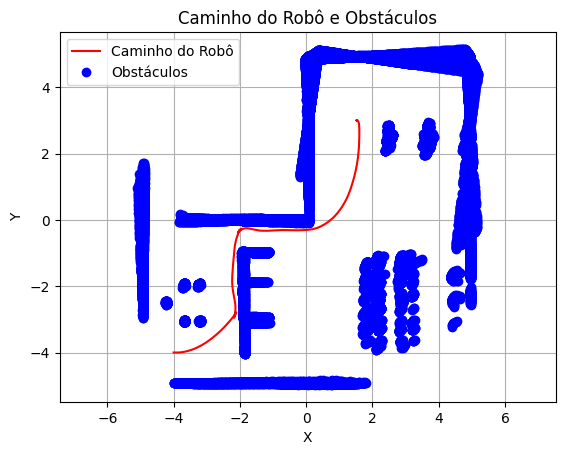

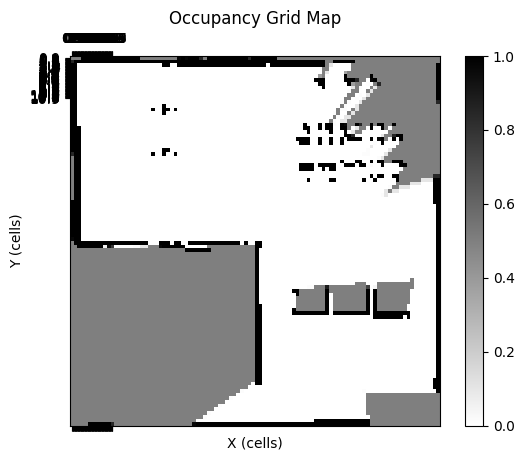

In [617]:
sim.startSimulation()

for qgoal in qgoals:
        reference_frame_position = qgoal.copy()
        reference_frame_position.append(0)
        navigation(np.array(qgoal))

sim.stopSimulation()

# Após o término da simulação
# -------------------------- Plotando o caminho do robô -------------------------
robot_path = np.array(robot_path)
plt.plot(robot_path[:, 0], robot_path[:, 1], '-r', label='Caminho do Robô')
obstacle_points = np.array(obstacle_points)
plt.plot(obstacle_points[:, 0], obstacle_points[:, 1], 'o', color='b', label='Obstáculos')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Caminho do Robô e Obstáculos')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.savefig("robot_path_and_obstacles.png")
plt.show()

# ------------------ Plotando o occupancy grid -----------------
fig, ax = plt.subplots()

# Exibir a matriz do Occupancy Grid
cax = ax.matshow(grid.T, cmap='gray_r', vmin=0, vmax=1)

# Adicionar uma barra de cores para referência
fig.colorbar(cax)

# Definir título e rótulos dos eixos
ax.set_title('Occupancy Grid Map')
ax.set_xlabel('X (cells)')
ax.set_ylabel('Y (cells)')

# Plotando as linhas do grid para facilitar a visualização
ax.set_xticks(np.arange(0, MAP_DIMS[1]+1, CELL_SIZE))
ax.set_yticks(np.arange(0, MAP_DIMS[0]+1, CELL_SIZE))
# ax.invert_yaxis()
# ax.set_xticklabels(ticks)
# ax.set_yticklabels(ticks)


#------------------------------- OCCUPANCY GRID  FIGURE ----------------------- 
# fig = plt.figure(figsize=(8,8), dpi=100)
# ax = fig.add_subplot(111, aspect='equal')
# ax.set_title('Occupancy Grid Map')


# Salvar a figura como uma imagem
plt.savefig("occupancy_grid_map.png")
plt.show()